In [1]:
#import modules

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

2024-08-20 16:48:12.580212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 16:48:12.580322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 16:48:12.716738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Base_dir='/kaggle/input/flickr8k' 
working_dir='/kaggle/working'

In [3]:
#Extract Image Features

model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
features={}
directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature
    
    
    
    

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1724172515.249625      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
#Store features in pickle
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'),'wb'))

In [6]:
#load features from pickle
with open(os.path.join(working_dir,'features.pkl'),'rb') as file:
    features=pickle.load(file)

In [7]:
#Load The captions data
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_doc=File.read()

In [8]:
#Create mapping of image To Captions
mapping={}
for line in tqdm(captions_doc.split('\n')):
    tokens=line.split(',')
    if(len(line)<2):
        continue
    image_id,caption=tokens[0],tokens[1:]
    image_id=image_id.split('.')[0]
    caption=" ".join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
def Clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq'+" ".join([word for word in caption.split() if len(word)>1])+'endseq'
            captions[i]=caption
        
    
    

In [10]:
Clean(mapping)

In [11]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

In [12]:
#Tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [13]:
#Find the maximum length of the caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length


33

# TRAIN TEST SPLIT

In [14]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.9)
train=image_ids[:split]
test=image_ids[split:]

In [15]:
#Create data generator to get data in batch 
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n=n+1
            captions=mapping[key]
            for caption in captions:
                seq=tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if(n==batch_size):
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield {"image":X1,"text":X2},y
                n=0;
                X1,X2,y=list(),list(),list()
                
            
                    
                

# **MODEL CREATION**


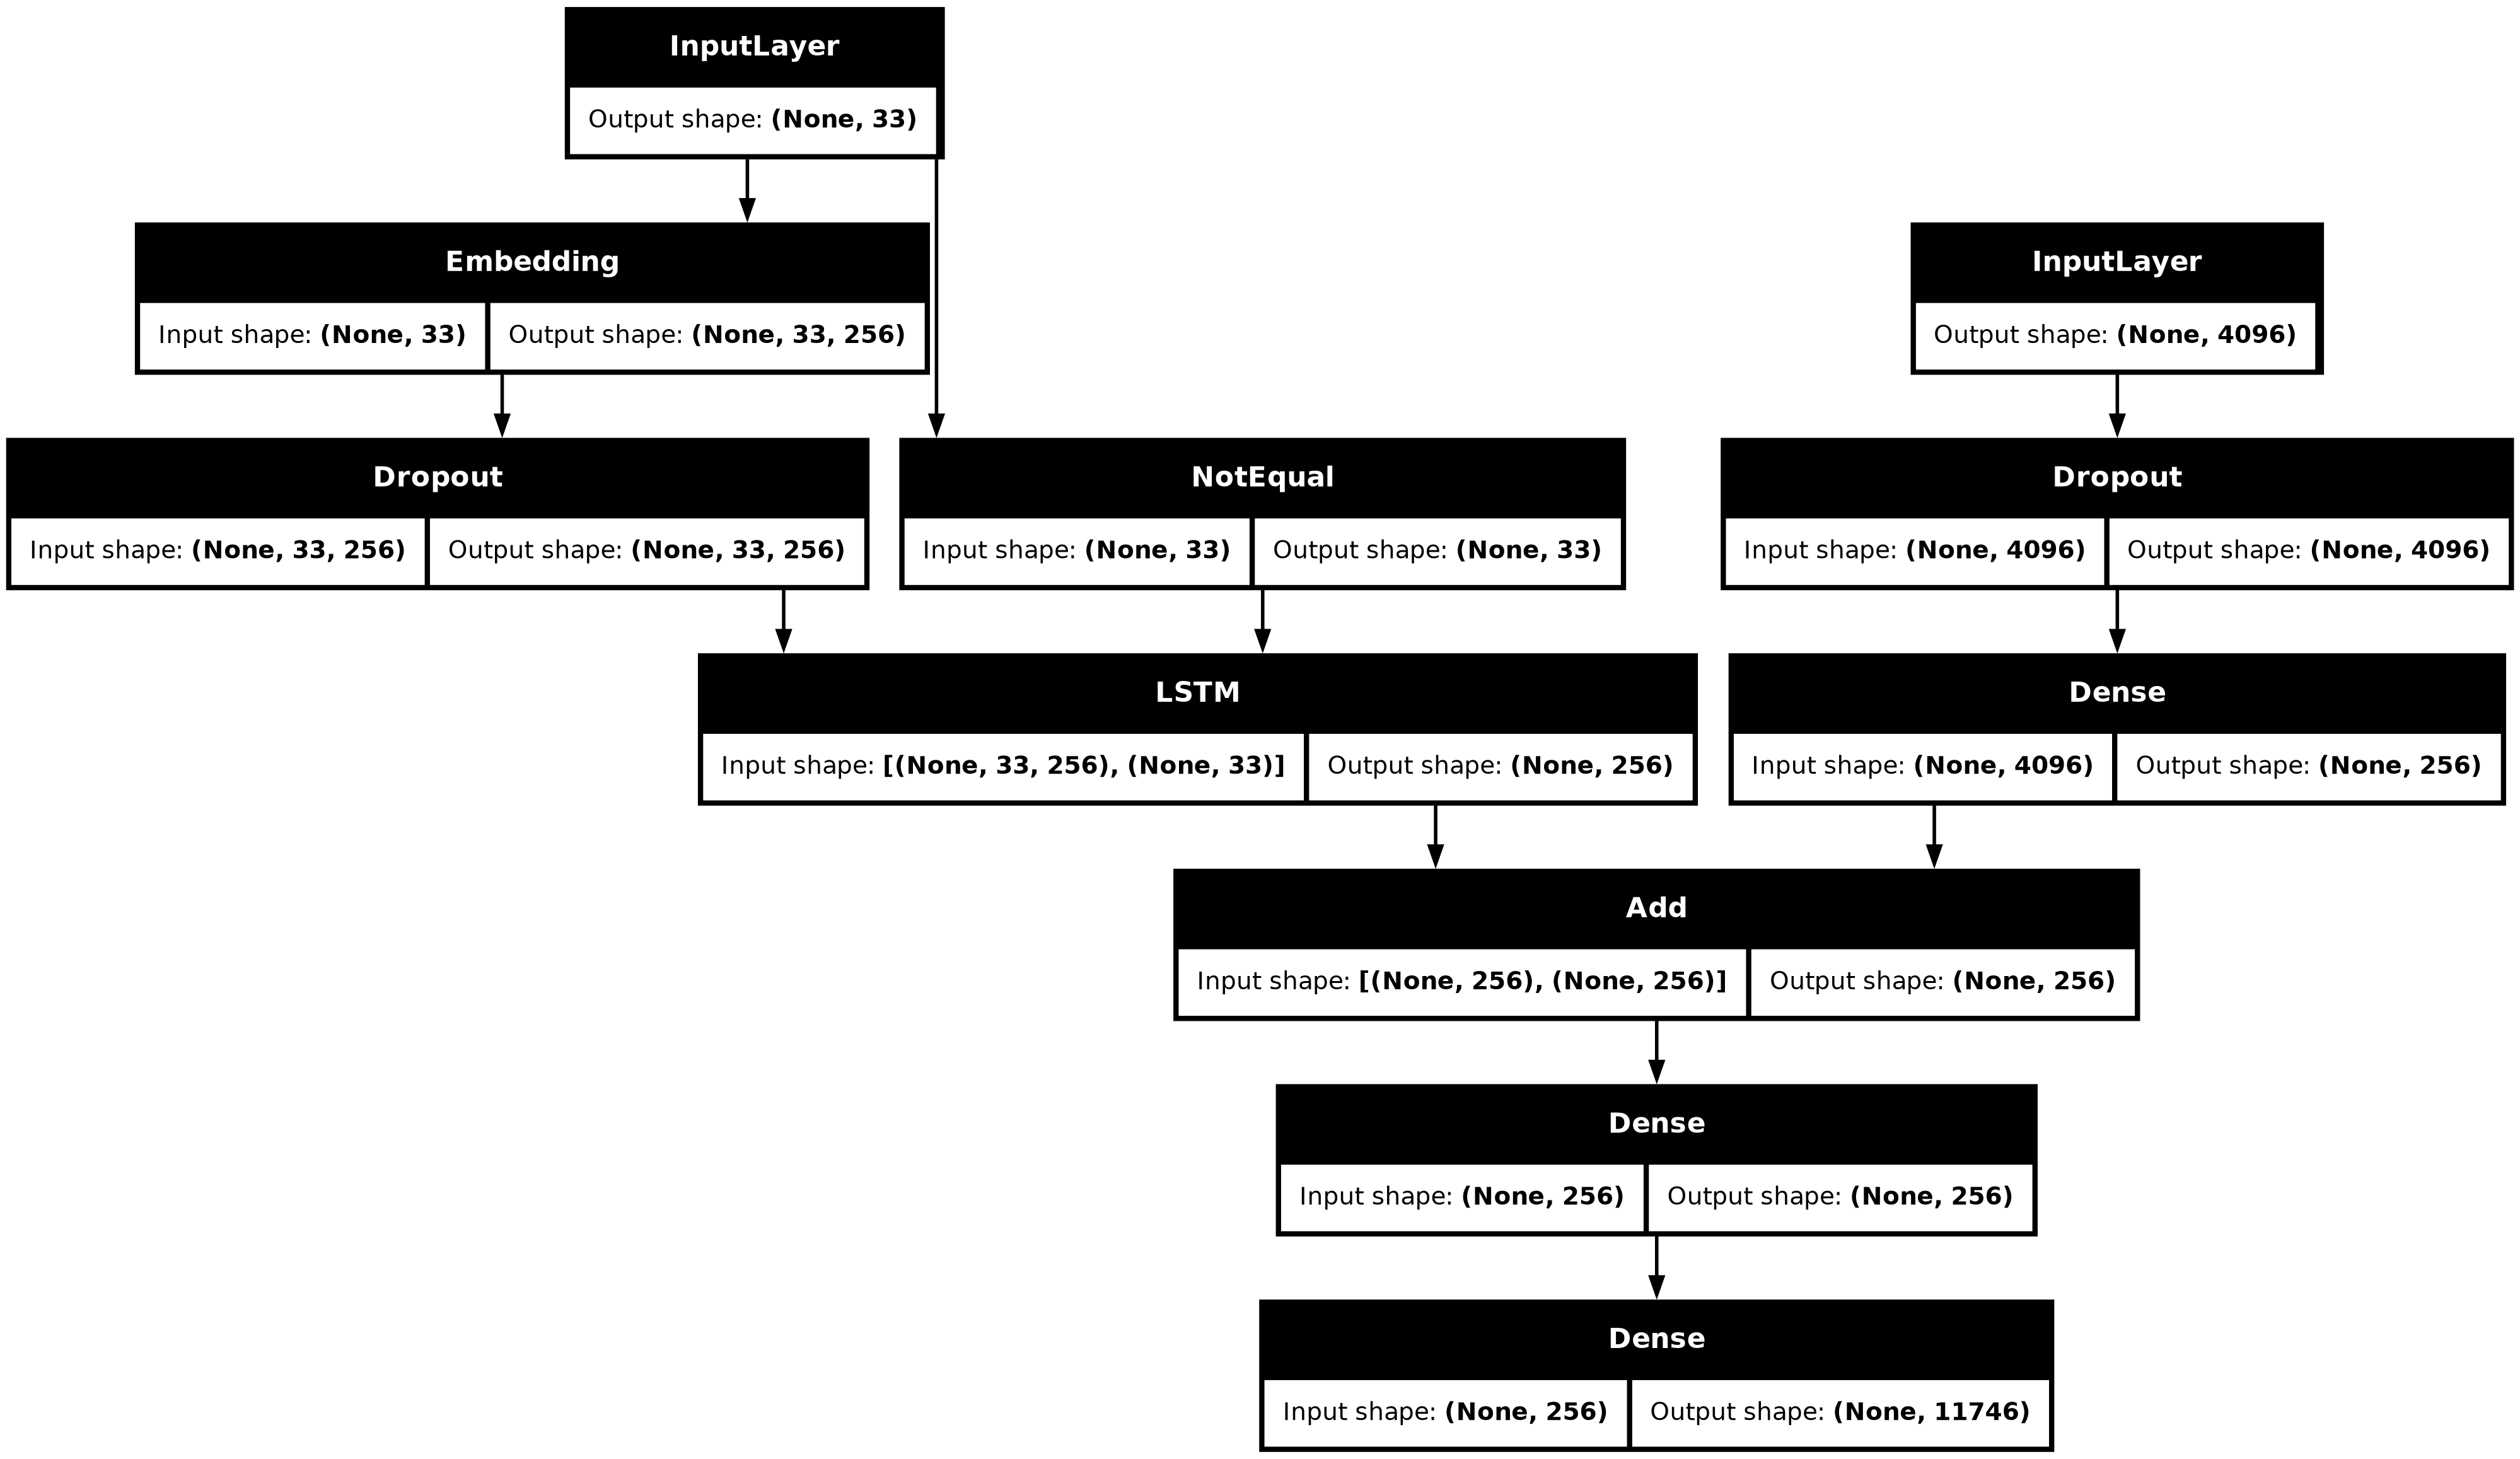

In [16]:
#Encoder model
#Image Feature layers
inputs1=Input(shape=(4096,),name="image")
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#Sequence Feature Layers
inputs2=Input(shape=(max_length,),name="text")
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256,return_sequences=False,use_cudnn=False)(se2)


#Decoder Model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True)


In [17]:
epochs=38
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 26:11 7s/step - loss: 9.3639

W0000 00:00:1724173159.328145      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173159.376776      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173159.430499      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 16:38 4s/step - loss: 9.2828

W0000 00:00:1724173163.767621      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173163.770572      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173163.816267      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173163.867696      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 16:36 4s/step - loss: 9.1642

W0000 00:00:1724173168.239514      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173168.281126      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173168.325173      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 16:41 4s/step - loss: 8.9948

W0000 00:00:1724173172.797426      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173172.800451      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173172.846211      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173172.898069      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 16:41 5s/step - loss: 8.8509

W0000 00:00:1724173177.367765      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173177.370927      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173177.416645      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173177.468187      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  6/227 ━━━━━━━━━━━━━━━━━━━━ 16:27 4s/step - loss: 8.7213

W0000 00:00:1724173181.690300      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173181.732148      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173181.776154      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 16:21 4s/step - loss: 8.6023

W0000 00:00:1724173186.088833      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173186.137741      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173186.191429      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 16:18 4s/step - loss: 8.4939

W0000 00:00:1724173190.609897      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173190.613080      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173190.658971      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173190.709655      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 16:16 4s/step - loss: 8.3985

W0000 00:00:1724173195.149371      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173195.198147      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173195.251059      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 16:14 4s/step - loss: 8.3138

W0000 00:00:1724173199.756063      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173199.804978      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173199.858398      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 16:10 4s/step - loss: 8.2368

W0000 00:00:1724173204.284871      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173204.288350      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173204.333076      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173204.383897      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 16:07 5s/step - loss: 8.1682

W0000 00:00:1724173208.852098      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173208.900737      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173208.953397      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 8.0499

W0000 00:00:1724173213.463511      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173213.466410      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173213.512463      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173213.563137      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 7.9980

W0000 00:00:1724173217.895671      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173217.937389      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173217.982684      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 7.9511

W0000 00:00:1724173222.318674      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173222.321694      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173222.367171      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173222.416694      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 14:47 4s/step - loss: 7.9075

W0000 00:00:1724173226.937205      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173226.940492      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173226.985316      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173227.035009      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 14:47 4s/step - loss: 7.8658

W0000 00:00:1724173231.482709      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173231.485953      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173231.530689      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173231.584307      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 14:47 4s/step - loss: 7.8274

W0000 00:00:1724173236.172492      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173236.175339      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173236.221625      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173236.272132      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 14:47 4s/step - loss: 7.7917

W0000 00:00:1724173240.752198      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173240.755430      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173240.799774      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173240.848802      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 14:45 4s/step - loss: 7.7577

W0000 00:00:1724173245.284735      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173245.287868      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173245.333358      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173245.390952      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 14:43 4s/step - loss: 7.7254

W0000 00:00:1724173249.838817      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173249.880125      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173249.923400      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 13:59 4s/step - loss: 7.6658

W0000 00:00:1724173254.446197      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173254.495381      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173254.548633      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 13:22 4s/step - loss: 7.6123

W0000 00:00:1724173259.144447      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173259.147455      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173259.192735      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173259.250650      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 13:24 4s/step - loss: 7.5879

W0000 00:00:1724173263.878954      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173263.927224      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173263.980427      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 13:24 4s/step - loss: 7.5645

W0000 00:00:1724173268.509125      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173268.511941      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173268.557395      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173268.606389      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 29/227 ━━━━━━━━━━━━━━━━━━━━ 13:24 4s/step - loss: 7.5421

W0000 00:00:1724173273.101210      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173273.149841      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173273.202349      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 30/227 ━━━━━━━━━━━━━━━━━━━━ 13:24 4s/step - loss: 7.5205

W0000 00:00:1724173277.688846      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173277.691992      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173277.737676      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173277.788273      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 13:22 4s/step - loss: 7.4998

W0000 00:00:1724173282.193287      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173282.196209      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173282.242325      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173282.293315      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 12:53 4s/step - loss: 7.4605

W0000 00:00:1724173286.870552      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173286.873277      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173286.917937      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173286.967664      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 34/227 ━━━━━━━━━━━━━━━━━━━━ 12:53 4s/step - loss: 7.4419

W0000 00:00:1724173291.532546      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173291.535549      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173291.581458      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173291.635986      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 12:52 4s/step - loss: 7.4237

W0000 00:00:1724173296.149643      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173296.198358      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173296.255869      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 12:51 4s/step - loss: 7.4060

W0000 00:00:1724173300.793622      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173300.842027      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173300.894371      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 12:51 4s/step - loss: 7.3889

W0000 00:00:1724173305.431480      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173305.434225      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173305.479166      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173305.529740      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 12:50 4s/step - loss: 7.3724

W0000 00:00:1724173310.103925      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173310.151620      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173310.201983      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 12:48 4s/step - loss: 7.3564

W0000 00:00:1724173314.678125      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173314.681665      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173314.726826      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173314.776787      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 12:47 4s/step - loss: 7.3408

W0000 00:00:1724173319.320038      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173319.322955      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173319.369286      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173319.420013      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 12:45 4s/step - loss: 7.3257

W0000 00:00:1724173323.969278      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173323.972592      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173324.018474      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173324.069737      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 12:44 4s/step - loss: 7.3111

W0000 00:00:1724173328.741350      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173328.744105      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173328.789748      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173328.839377      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 12:42 4s/step - loss: 7.2968

W0000 00:00:1724173333.336760      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173333.339890      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173333.384480      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173333.433450      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 44/227 ━━━━━━━━━━━━━━━━━━━━ 12:39 4s/step - loss: 7.2829

W0000 00:00:1724173337.837778      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173337.840754      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173337.885873      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173337.936432      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 12:37 4s/step - loss: 7.2693

W0000 00:00:1724173342.414483      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173342.417404      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173342.462082      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173342.511071      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 12:34 4s/step - loss: 7.2561

W0000 00:00:1724173346.944123      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173346.985379      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173347.028892      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 12:32 4s/step - loss: 7.2430

W0000 00:00:1724173351.535144      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173351.538133      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173351.582485      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173351.638461      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 12:29 4s/step - loss: 7.2301

W0000 00:00:1724173356.235870      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173356.239027      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173356.284353      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173356.335611      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 12:26 4s/step - loss: 7.2176

W0000 00:00:1724173360.756697      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173360.797415      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173360.840842      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 11:48 4s/step - loss: 7.1818

W0000 00:00:1724173365.725103      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173365.727907      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173365.773413      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173365.823097      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 11:29 4s/step - loss: 7.1592

W0000 00:00:1724173370.447152      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173370.450157      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173370.496093      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173370.548725      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 11:26 4s/step - loss: 7.1482

W0000 00:00:1724173375.023230      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173375.065067      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173375.115884      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - loss: 7.1378

W0000 00:00:1724173379.743401      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173379.794389      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173379.849466      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 11:23 4s/step - loss: 7.1276

W0000 00:00:1724173384.318651      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173384.367341      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173384.420504      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 11:20 4s/step - loss: 7.1176

W0000 00:00:1724173389.018269      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173389.021286      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173389.066612      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173389.116467      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - loss: 7.0982

W0000 00:00:1724173393.701666      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173393.704618      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173393.749661      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173393.800166      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - loss: 7.0888

W0000 00:00:1724173398.441022      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173398.489905      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173398.543094      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 62/227 ━━━━━━━━━━━━━━━━━━━━ 10:59 4s/step - loss: 7.0796

W0000 00:00:1724173403.026228      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173403.029379      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173403.075123      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173403.127172      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 10:56 4s/step - loss: 7.0706

W0000 00:00:1724173407.667851      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173407.709132      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173407.752406      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/227 ━━━━━━━━━━━━━━━━━━━━ 10:54 4s/step - loss: 7.0617

W0000 00:00:1724173412.244287      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173412.247053      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173412.291420      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173412.339960      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 10:38 4s/step - loss: 7.0445

W0000 00:00:1724173416.993585      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173417.041797      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173417.093058      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 10:36 4s/step - loss: 7.0361

W0000 00:00:1724173421.718520      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173421.722212      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173421.767415      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173421.818070      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/227 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - loss: 7.0278

W0000 00:00:1724173426.353738      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173426.356557      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173426.401825      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173426.452413      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - loss: 7.0198

W0000 00:00:1724173430.999439      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173431.002336      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173431.048390      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173431.098933      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 71/227 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - loss: 7.0041

W0000 00:00:1724173435.789124      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173435.792046      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173435.836312      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173435.886314      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 10:13 4s/step - loss: 6.9963

W0000 00:00:1724173440.418243      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173440.421530      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173440.466252      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173440.515428      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - loss: 6.9887

W0000 00:00:1724173445.038573      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173445.080079      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173445.123864      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - loss: 6.9812

W0000 00:00:1724173449.811202      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173449.860922      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173449.919789      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 10:06 4s/step - loss: 6.9737

W0000 00:00:1724173454.516458      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173454.519417      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173454.564541      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173454.614356      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - loss: 6.9664

W0000 00:00:1724173459.151628      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173459.154873      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173459.199670      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173459.249000      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 77/227 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - loss: 6.9592

W0000 00:00:1724173463.749232      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173463.752161      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173463.797251      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173463.846207      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 9:58 4s/step - loss: 6.9521 

W0000 00:00:1724173468.402589      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173468.405548      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173468.450239      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173468.499219      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - loss: 6.9248

W0000 00:00:1724173473.626966      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173473.675467      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173473.725905      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 9:20 4s/step - loss: 6.9183

W0000 00:00:1724173478.265485      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173478.315133      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173478.368704      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - loss: 6.9118

W0000 00:00:1724173482.926351      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173482.929308      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173482.974970      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173483.026339      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/227 ━━━━━━━━━━━━━━━━━━━━ 9:14 4s/step - loss: 6.9054

W0000 00:00:1724173487.612849      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173487.615639      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173487.660989      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173487.711924      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - loss: 6.8929

W0000 00:00:1724173492.397596      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173492.400591      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173492.446446      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173492.496835      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 8:49 4s/step - loss: 6.8808

W0000 00:00:1724173497.281652      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173497.329072      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173497.380112      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - loss: 6.8748

W0000 00:00:1724173501.925425      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173501.928746      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173501.974031      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173502.025398      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - loss: 6.8689

W0000 00:00:1724173506.635318      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173506.638354      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173506.684088      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173506.736784      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 8:42 4s/step - loss: 6.8631

W0000 00:00:1724173511.252835      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173511.294299      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173511.337953      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - loss: 6.8517

W0000 00:00:1724173516.126576      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173516.174929      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173516.227435      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 97/227 ━━━━━━━━━━━━━━━━━━━━ 8:09 4s/step - loss: 6.8350

W0000 00:00:1724173521.134980      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173521.183759      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173521.236773      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - loss: 6.8296

W0000 00:00:1724173525.816733      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173525.819835      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173525.865617      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173525.916056      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/227 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - loss: 6.8242

W0000 00:00:1724173530.490311      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173530.493280      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173530.538205      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173530.588594      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - loss: 6.8188

W0000 00:00:1724173535.146350      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173535.149145      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173535.193763      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173535.249776      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/227 ━━━━━━━━━━━━━━━━━━━━ 7:59 4s/step - loss: 6.8136

W0000 00:00:1724173539.903326      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173539.906110      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173539.951906      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173540.001671      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - loss: 6.8032

W0000 00:00:1724173544.741819      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173544.744878      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173544.790308      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173544.838957      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - loss: 6.7930

W0000 00:00:1724173549.495480      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173549.542753      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173549.594036      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - loss: 6.7783

W0000 00:00:1724173554.341753      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173554.388975      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173554.440145      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:09 4s/step - loss: 6.7686

W0000 00:00:1724173559.139627      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173559.142514      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173559.187840      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173559.237480      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/227 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - loss: 6.7639

W0000 00:00:1724173563.808955      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173563.812005      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173563.856573      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173563.906515      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - loss: 6.7592

W0000 00:00:1724173568.421223      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173568.462592      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173568.507716      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/227 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - loss: 6.7411

W0000 00:00:1724173573.360818      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173573.408924      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173573.462109      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - loss: 6.7367

W0000 00:00:1724173578.043831      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173578.046764      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173578.091841      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173578.140807      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/227 ━━━━━━━━━━━━━━━━━━━━ 6:34 4s/step - loss: 6.7324

W0000 00:00:1724173582.667780      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173582.671002      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173582.716680      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173582.766739      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/227 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - loss: 6.7238

W0000 00:00:1724173587.447440      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173587.450426      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173587.495596      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173587.546549      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


121/227 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - loss: 6.7196

W0000 00:00:1724173592.020665      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173592.062518      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173592.106643      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - loss: 6.7113

W0000 00:00:1724173596.876070      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173596.923681      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173596.974246      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:03 4s/step - loss: 6.7032

W0000 00:00:1724173601.655294      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173601.702515      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173601.754833      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/227 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - loss: 6.6952

W0000 00:00:1724173606.659850      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173606.707701      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173606.758164      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - loss: 6.6874

W0000 00:00:1724173611.553843      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173611.600375      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173611.650644      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - loss: 6.6835

W0000 00:00:1724173616.255557      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173616.297424      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173616.342668      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - loss: 6.6759

W0000 00:00:1724173621.130350      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173621.178682      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173621.238521      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:20 3s/step - loss: 6.6646

W0000 00:00:1724173626.251556      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173626.293423      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173626.337452      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:17 3s/step - loss: 6.6609

W0000 00:00:1724173630.901490      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173630.904308      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173630.949789      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173630.999541      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/227 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - loss: 6.6572

W0000 00:00:1724173635.586915      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173635.590222      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173635.634590      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173635.684691      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/227 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - loss: 6.6535

W0000 00:00:1724173640.386252      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173640.389468      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173640.435287      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173640.491031      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/227 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - loss: 6.6499

W0000 00:00:1724173645.106813      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173645.155526      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173645.208420      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/227 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - loss: 6.6463

W0000 00:00:1724173649.803645      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173649.806651      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173649.852667      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173649.907969      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:04 4s/step - loss: 6.6427

W0000 00:00:1724173654.475124      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173654.516878      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173654.567591      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/227 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - loss: 6.6392

W0000 00:00:1724173659.136671      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173659.178488      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173659.222413      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/227 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - loss: 6.6356

W0000 00:00:1724173663.790777      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173663.793643      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173663.839635      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173663.889516      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/227 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - loss: 6.6252

W0000 00:00:1724173668.717693      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173668.759146      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173668.803033      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/227 ━━━━━━━━━━━━━━━━━━━━ 4:41 4s/step - loss: 6.6218

W0000 00:00:1724173673.379656      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173673.382516      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173673.427563      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173673.477775      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/227 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - loss: 6.6184

W0000 00:00:1724173678.071035      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173678.074146      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173678.119510      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173678.169966      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - loss: 6.6150

W0000 00:00:1724173682.742993      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173682.792544      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173682.845534      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 4:32 4s/step - loss: 6.6116

W0000 00:00:1724173687.439569      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173687.442543      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173687.487336      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173687.543669      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - loss: 6.5950

W0000 00:00:1724173692.525125      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173692.571343      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173692.621292      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - loss: 6.5885

W0000 00:00:1724173697.302886      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173697.344002      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173697.387145      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 3:58 3s/step - loss: 6.5853

W0000 00:00:1724173702.026339      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173702.029310      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173702.074828      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173702.124632      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/227 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - loss: 6.5693

W0000 00:00:1724173707.292136      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173707.339094      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173707.390278      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - loss: 6.5567

W0000 00:00:1724173712.386442      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173712.432827      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173712.482967      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/227 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - loss: 6.5473

W0000 00:00:1724173717.253464      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173717.300310      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173717.349874      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


172/227 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - loss: 6.5411

W0000 00:00:1724173721.970284      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173722.011889      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173722.055779      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/227 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - loss: 6.5229

W0000 00:00:1724173727.362447      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173727.409346      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173727.460413      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/227 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - loss: 6.5169

W0000 00:00:1724173732.194792      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173732.242460      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173732.294314      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/227 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - loss: 6.5139

W0000 00:00:1724173736.912518      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173736.915497      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173736.960584      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173737.011103      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/227 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - loss: 6.5109

W0000 00:00:1724173741.591102      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173741.594294      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173741.640109      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173741.690998      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - loss: 6.4877

W0000 00:00:1724173747.389153      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173747.392108      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173747.436622      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173747.487947      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - loss: 6.4848

W0000 00:00:1724173752.064796      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173752.114649      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173752.174348      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/227 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - loss: 6.4791

W0000 00:00:1724173756.958928      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173756.961834      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173757.006625      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173757.056799      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/227 ━━━━━━━━━━━━━━━━━━━━ 1:28 3s/step - loss: 6.4651

W0000 00:00:1724173762.262106      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173762.308723      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173762.358858      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:25 3s/step - loss: 6.4623

W0000 00:00:1724173766.971314      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173766.974376      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173767.019882      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173767.069858      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/227 ━━━━━━━━━━━━━━━━━━━━ 1:19 3s/step - loss: 6.4567

W0000 00:00:1724173771.933379      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173771.981460      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173772.032314      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:13 3s/step - loss: 6.4512

W0000 00:00:1724173776.776646      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173776.779728      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173776.826098      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173776.879213      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - loss: 6.4403

W0000 00:00:1724173781.754762      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173781.841320      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 6.4189

W0000 00:00:1724173787.362267      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173787.410222      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173787.462807      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/227 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 6.4137

W0000 00:00:1724173792.218899      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173792.221853      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173792.267575      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173792.318997      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 6.4084

W0000 00:00:1724173797.205579      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173797.208442      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173797.254236      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173797.305698      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/227 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 6.4058

W0000 00:00:1724173801.830623      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173801.872186      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173801.916120      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


222/227 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 6.4007

W0000 00:00:1724173806.690246      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173806.693219      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173806.738780      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173806.788124      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/227 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6.3929

W0000 00:00:1724173811.683244      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173811.732228      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173811.785850      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 6.3904

W0000 00:00:1724173816.293550      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173816.334721      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724173816.377937      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 664s 3s/step - loss: 6.3853
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 4.6068
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 4.0054
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 3.6433
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 3.3862
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 3.1863
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 3.0448
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.9255
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.8199
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 2.7345
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 2.6562
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.5905
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.5314
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.4790
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.4284
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 2.3793
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.3373

In [18]:
model.save(working_dir+'/best_model.h5')


In [19]:
#Generate Captions for images
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if(index==integer):
            return word
    return None




In [20]:
#Generate Caption for an image

def predict_caption(model,image,tokenizer,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],max_length)
        yhat=model.predict([image,sequence],verbose=0)
        yhat=np.argmax(yhat)
        word=idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word=='endseq':
            break
    return in_text
        
    

In [21]:
#Validate with Test data
from nltk.translate.bleu_score import corpus_bleu
actual,predicted=list(),list()

for key in tqdm(test):
    captions=mapping[key]
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    y_pred=y_pred.split()
    actual_captions=[caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred)
    

  0%|          | 0/810 [00:00<?, ?it/s]

In [22]:
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

BLEU-1: 0.254395
BLEU-2: 0.120395


# VISUALIZE THE RESULTS

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    image_path=os.path.join(Base_dir,"Images",image_name)
    image=Image.open(image_path)
    captions=mapping[image_id]
    print('-------Actual-------')
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
    print('-------Predicted---------')
    print(y_pred)
    plt.imshow(image)


-------Actual-------
startseqchild in pink dress is climbing up set of stairs in an entry wayendseq
startseqgirl going into wooden buildingendseq
startseqlittle girl climbing into wooden playhouseendseq
startseqlittle girl climbing the stairs to her playhouseendseq
startseqlittle girl in pink dress going into wooden cabinendseq
-------Predicted---------
startseq the girl is wearing black jacket and jeans and jeans and jeans and jeans and jeans endseq


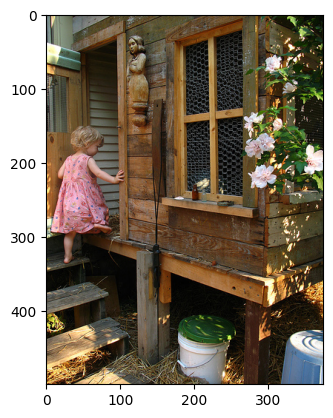

In [24]:
generate_caption('1000268201_693b08cb0e.jpg')